In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Damped Oscillator with RK4 Method

**Goal**: Reproduce the damped harmonic oscillator results from the Asaf Szulc thesis on modeling MOTs. A damped harmonic oscillator is a good approximation for each dimension of a MOT for small velocities and positions near the center of the trap.

Damped harmonic oscillator in 1D takes the form:
$$ F(x,v) = m\dot{x} = -\beta \dot{x} - \kappa x $$

This is a second order ODE. We can write it in terms of two coupled first-order differential equations.

$$ \dot{x} = v $$
$$ \dot{v} = \frac{F(x, v)}{m} $$

Now we can apply RK4 given two initial conditions (x0, v0).
See Szulc thesis for additional info.

In [134]:
# Useful constants

# Rubidium-87 mass:
mass_Rb87 = 1.4431609 * 10**(-25) # kg

# Damping constants
beta = 3.35 * 10**(-23) # kg/s
kappa = 1.53 * 10**(-17) # kg/s^2

In [135]:
# Function to compute force based on x, v.
def Force(x, v):
    return -beta*v - kappa*x

In [199]:
# Implementation of (4th order Runge-Kutta) RK4 iterative method
# for solving first order differential equations.
# See Szulc p. 41-42.

##############
# RK4 METHOD #
##############
# x0, v0: intial position, velocity
# m: mass of the particle
# dt: time step size in seconds
# num_timesteps: number of time steps
def runRK4(x0, v0, m=mass_Rb87, dt=10 * 10**(-6), num_timesteps=1000):
    # Initialize state:
    xn = x0
    vn = v0
    
    # Data storage
    positions = []
    positions.append(xn)  # Store x0
    velocities = []
    velocities.append(vn) # Store v0
    times = []
    times.append(0)
    
    # RK4 Loop
    for j in range(0, num_timesteps):
        K1 = Force(xn, vn)/m
        L1 = vn
        
        K2 = Force(xn + dt*L1/2, vn + dt*K1/2)/m
        L2 = vn + dt*K1/2
        
        K3 = Force(xn + dt*L2/2, vn + dt*K2/2)/m
        L3 = vn + dt*K2/2
        
        K4 = Force(xn + dt*L3, vn + dt*K3)/m
        L4 = vn + dt*K3
        
        # Debugging:
        #print("########################################")
        #print(" TIME STEP: ", str(j+1))
        #print("------------------------------------------")
        #print("K_1: ", K1, "K_2: ", K2, "K_3: ", K3, "K_4: ", K4)
        #print("L_1: ", L1, "L_2: ", L2, "L_3: ", L3, "L_4: ", L4)
        
        # Update xn and vn
        xn = xn + (dt/6)*(L1 + 2*L2 + 2*L3 + L4)
        vn = vn + (dt/6)*(K1 + 2*K2 + 2*K3 + K4)
        
        
        # Store these new xn, vn:
        positions.append(xn)
        velocities.append(vn)
        times.append((j+1) * dt)
    
    return np.array(times), np.array(positions), np.array(velocities)

### Euler's method 

In [217]:
def runEuler(x0, v0, m=mass_Rb87, dt=10 * 10**(-6), num_timesteps=1000):
    # Initialize state:
    xn = x0
    vn = v0
    
    # Data storage
    positions = []
    positions.append(xn)  # Store x0
    velocities = []
    velocities.append(vn) # Store v0
    times = []
    times.append(0)
    
    # Euler Loop
    for j in range(0, num_timesteps):
        vdot = Force(xn, vn)/m
        vn = vn + dt*vdot
        xn = xn + dt*vn
        positions.append(xn)
        velocities.append(vn)
        times.append((j+1)*dt)
    
    return np.array(times), np.array(positions), np.array(velocities)

### Analytical solution for the underdamped harmonic oscillator
For these beta, kappa in the MOT we have an underdamped harmonic oscillator. This is solved by
$$ x(t) = e^{-\delta t}(2A\cos(\phi + \omega t)) $$
where
$$ \delta = \frac{\beta}{2m}, \omega_0 = \sqrt{\frac{\kappa}{m}}, \omega = \sqrt{\omega_0^2 - \delta^2} $$
Applying initial conditions one finds:
$$ A = \frac{x_0}{2\cos(\phi)} $$
$$ \tan(\phi) = -\frac{\delta + (v_0/x_0)}{\omega} $$

In [218]:
def runAnalytical(x0, v0, m=mass_Rb87, dt=10 * 10**(-6), num_timesteps=1000):
    # Compute useful quantities
    delta = beta/(2*m)
    omega_0 = np.sqrt(kappa/m)
    omega = np.sqrt(omega_0**2 - delta**2)
    phi = np.arctan(-(delta + (v0/x0))/omega)
    A = x0/(2*np.cos(phi))
    
    # Time array
    times = np.arange(0, num_timesteps) * dt 

    #Generate position array
    x_theory = np.exp(-delta*times) * 2*A*np.cos(phi + omega*times)
    
    return times, x_theory

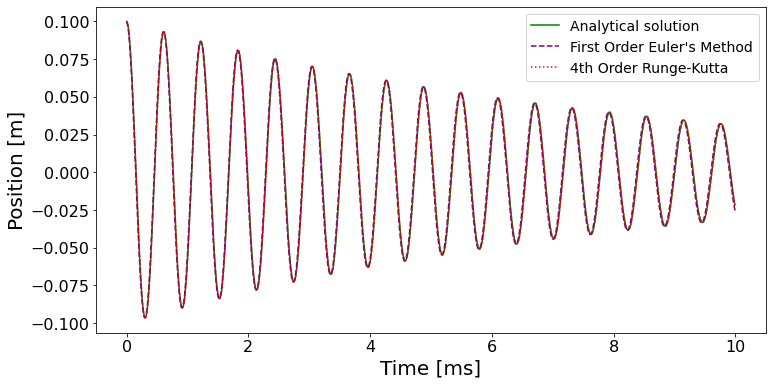

In [219]:
fig, ax = plt.subplots(figsize=(12, 6))

# Choose parameters
x0 = 0.1
v0 = 0
step_size = 10 * 10**(-6) # sec
timesteps = 1000

# Methods
# Analytical
times_A, x_A = runAnalytical(x0, v0, m=mass_Rb87, dt=step_size, num_timesteps=timesteps)
plt.plot(times_A*(10**(3)), x_A, label="Analytical solution", color="green")
# Euler
times_E, x_E, _ = runEuler(x0, v0, m=mass_Rb87, dt=step_size, num_timesteps=timesteps)
plt.plot(times_E*(10**3), x_E, color="purple", ls="--", label="First Order Euler's Method")
# RK4
times_RK4, x_RK4, _ = runRK4(x0, v0, m=mass_Rb87, dt=step_size, num_timesteps=timesteps)
plt.plot(times_RK4*(10**3), x_RK4, color="red", ls="dotted", label="4th Order Runge-Kutta")


plt.legend(fontsize=14)
plt.ylabel("Position [m]", fontsize=20)
plt.xlabel("Time [ms]", fontsize=20)
ax.tick_params(labelsize=16)